In [853]:
with open('libraries.py') as f:
    code = f.read()
exec(code)

with open('functions.py') as f:
    code = f.read()
exec(code)

In [854]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'

In [856]:
# Pick occupation and initialize variables
occupation = 'travelAgents'
occupation = 'insuranceUnderwriters'
# occupation = 'pileDriverOperators'
# occupation = 'dredgeOperators'
# occupation = 'gradersAndSorters'
# occupation = 'reinforcingIron'
# occupation = 'insuranceAppraisers'
# occupation = 'floorSanders'
# occupation = 'dataEntryKeyer'
# # occupation = 'athletesAndSportsCompetitors'
# # # occupation = 'shampooers'

GPT_input_occupation, plot_title_occupation, occupation_code, occupation_folder = pick_occupation(occupation)

In [857]:
# Manual DAG only available for travel agents and insurance underwriters
# if working w/ these two occupations include manual DAG too, else discard relevant code
manual_present = 0
if occupation == 'travelAgents' or occupation == 'insuranceUnderwriters':
    manual_present = 1

### Read Data

In [858]:
suffix = ''

if manual_present == 1:
    manual_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_{suffix}manual.csv')
firstLastTask_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_firstLastTask.csv')
firstLastTask_conditioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_{suffix}firstLastTask_conditioned.csv')
partitioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_partitioned.csv')
partitioned_conditioned_df = pd.read_csv(f'{occupation_folder}/{occupation}_costMin_{suffix}partitioned_conditioned.csv')


In [859]:
# get number of tasks in occupation
onet = pd.read_csv(f'{data_path}/data/onet_occupations_yearly.csv')
onet = onet.sort_values(by=['year', 'occ_code', 'occ_title', 'task_id'])
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# Get list of tasks
my_df = onet[(onet.occ_code == f'{occupation_code}') & (onet.year == 2023)]
tasks = my_df['task'].unique().tolist()
num_tasks = len(tasks)

In [860]:
def get_manual_to_machine_tasks(df):
    # Convert the string representation of lists into actual Python lists
    for col in ['optimal_scheme', 'optimal_scheme_manual_tasks']:
        df[col] = df[col].apply(ast.literal_eval)

    # Define a function to subtract lists in the next row from lists in the current row
    def subtract_lists(current_list, next_list):
        # Flatten lists for easier comparison
        current_flat = [item for sublist in current_list for item in sublist]
        next_flat = [item for sublist in next_list for item in sublist]
        
        # Subtract elements
        result_flat = [item for item in current_flat if item not in next_flat]
        
        # Rebuild the list of lists structure
        result_list = [[item] for item in result_flat]
        return result_list

    # Create the new column by applying the function to each row
    new_column = [[]]
    for i in range(1, len(df)):
        current_list = df.loc[i - 1, 'optimal_scheme_manual_tasks']
        next_list = df.loc[i, 'optimal_scheme_manual_tasks']
        new_column.append(subtract_lists(current_list, next_list))

    # Add the last element as an empty list (as there is no next row to subtract from)
    #new_column.append([])

    # Assign the new column to the DataFrame
    df['newly_automated_tasks'] = new_column
    
    # Replace empty lists with an empty string
    df['newly_automated_tasks'] = df['newly_automated_tasks'].apply(lambda x: '' if x == [] else x)

    return df

firstLastTask_df = get_manual_to_machine_tasks(firstLastTask_df)
firstLastTask_conditioned_df = get_manual_to_machine_tasks(firstLastTask_conditioned_df)
partitioned_df = get_manual_to_machine_tasks(partitioned_df)
partitioned_conditioned_df = get_manual_to_machine_tasks(partitioned_conditioned_df)

In [861]:
def substitute_lists(row):
    optimal_scheme_str = 'optimal_scheme'
    optimal_scheme_manual_tasks_str = 'optimal_scheme_manual_tasks'
    
    # Convert string representations of lists into actual lists
    list_a = row[optimal_scheme_str]
    list_b = row[optimal_scheme_manual_tasks_str]
    # list_a = ast.literal_eval(row[optimal_scheme_str])
    # list_b = ast.literal_eval(row[optimal_scheme_manual_tasks_str])
    
    # Iterate over elements in list_b
    for sublist_b in list_b:
        # Replace matching lists in list_a with the formatted string
        list_a = [
            f"<{sublist_b[0]}>" if sublist == sublist_b else sublist
            for sublist in list_a
        ]
    
    # Convert the list back to a string without quotes around "<x>"
    return "[" + ", ".join(
        str(item) if isinstance(item, list) else item
        for item in list_a
    ) + "]"

firstLastTask_df['pretty_name'] = firstLastTask_df.apply(substitute_lists, axis=1)
firstLastTask_conditioned_df['pretty_name'] = firstLastTask_conditioned_df.apply(substitute_lists, axis=1)
partitioned_df['pretty_name'] = partitioned_df.apply(substitute_lists, axis=1)
partitioned_conditioned_df['pretty_name'] = partitioned_conditioned_df.apply(substitute_lists, axis=1)

### Create new dataset comparing DAGs stats

In [862]:
cols_to_keep = ['alpha', 'cost', 'pretty_name', 'newly_automated_tasks', 'optimal_schemes_count']

if manual_present == 1:
    # prepare manual dataset
    manual_df = get_manual_to_machine_tasks(manual_df) 
    manual_df['pretty_name'] = manual_df.apply(substitute_lists, axis=1)
    
    # merge datasets
    comparison_df = pd.merge(manual_df[cols_to_keep], 
                            firstLastTask_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_M', '_FLT'))
    comparison_df = pd.merge(comparison_df,
                            firstLastTask_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')
    comparison_df = pd.merge(comparison_df,
                            partitioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_CFLT', '_P'))
    comparison_df = pd.merge(comparison_df,
                            partitioned_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')

    # change column names
    comparison_df = comparison_df.rename(columns={'pretty_name': 'optimal_scheme_CP',
                                                'cost': 'cost_CP', 
                                                'newly_automated_tasks': 'newly_automated_tasks_CP',
                                                'optimal_schemes_count': 'optimal_schemes_count_CP'})
else:
    # merge datasets
    comparison_df = pd.merge(firstLastTask_df[cols_to_keep], 
                            firstLastTask_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer',
                            suffixes=('_FLT', '_CFLT'))
    comparison_df = pd.merge(comparison_df,
                            partitioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')
    comparison_df = pd.merge(comparison_df,
                            partitioned_conditioned_df[cols_to_keep], 
                            on=['alpha'], 
                            how = 'outer')

    # change column names
    comparison_df = comparison_df.rename(columns={'pretty_name_x': 'optimal_scheme_P',
                                                'pretty_name_y': 'optimal_scheme_CP', 
                                                'cost_x': 'cost_P',
                                                'cost_y': 'cost_CP', 
                                                'newly_automated_tasks_x': 'newly_automated_tasks_P',
                                                'newly_automated_tasks_y': 'newly_automated_tasks_CP',
                                                'optimal_schemes_count_x': 'optimal_schemes_count_P',
                                                'optimal_schemes_count_y': 'optimal_schemes_count_CP'})

# hacky way to fix column names after merge
comparison_df.columns = comparison_df.columns.str.replace('pretty_name', 'optimal_scheme')

for col in comparison_df.columns:
    if "optimal_scheme_" in col:
        # Create a new column indicating where the value changes
        change_col = col + '_change'
        comparison_df[change_col] = (comparison_df[col] != comparison_df[col].shift()).cumsum() - 1


# # change ordering of columns
# sorted_cols = sorted(comparison_df.columns, key=lambda x: x.split('_')[-1])
# comparison_df = comparison_df[sorted_cols]

# save output
comparison_df.to_csv(f'{occupation_folder}/{occupation}_costMin_comparison.csv', index=False)

## Plots

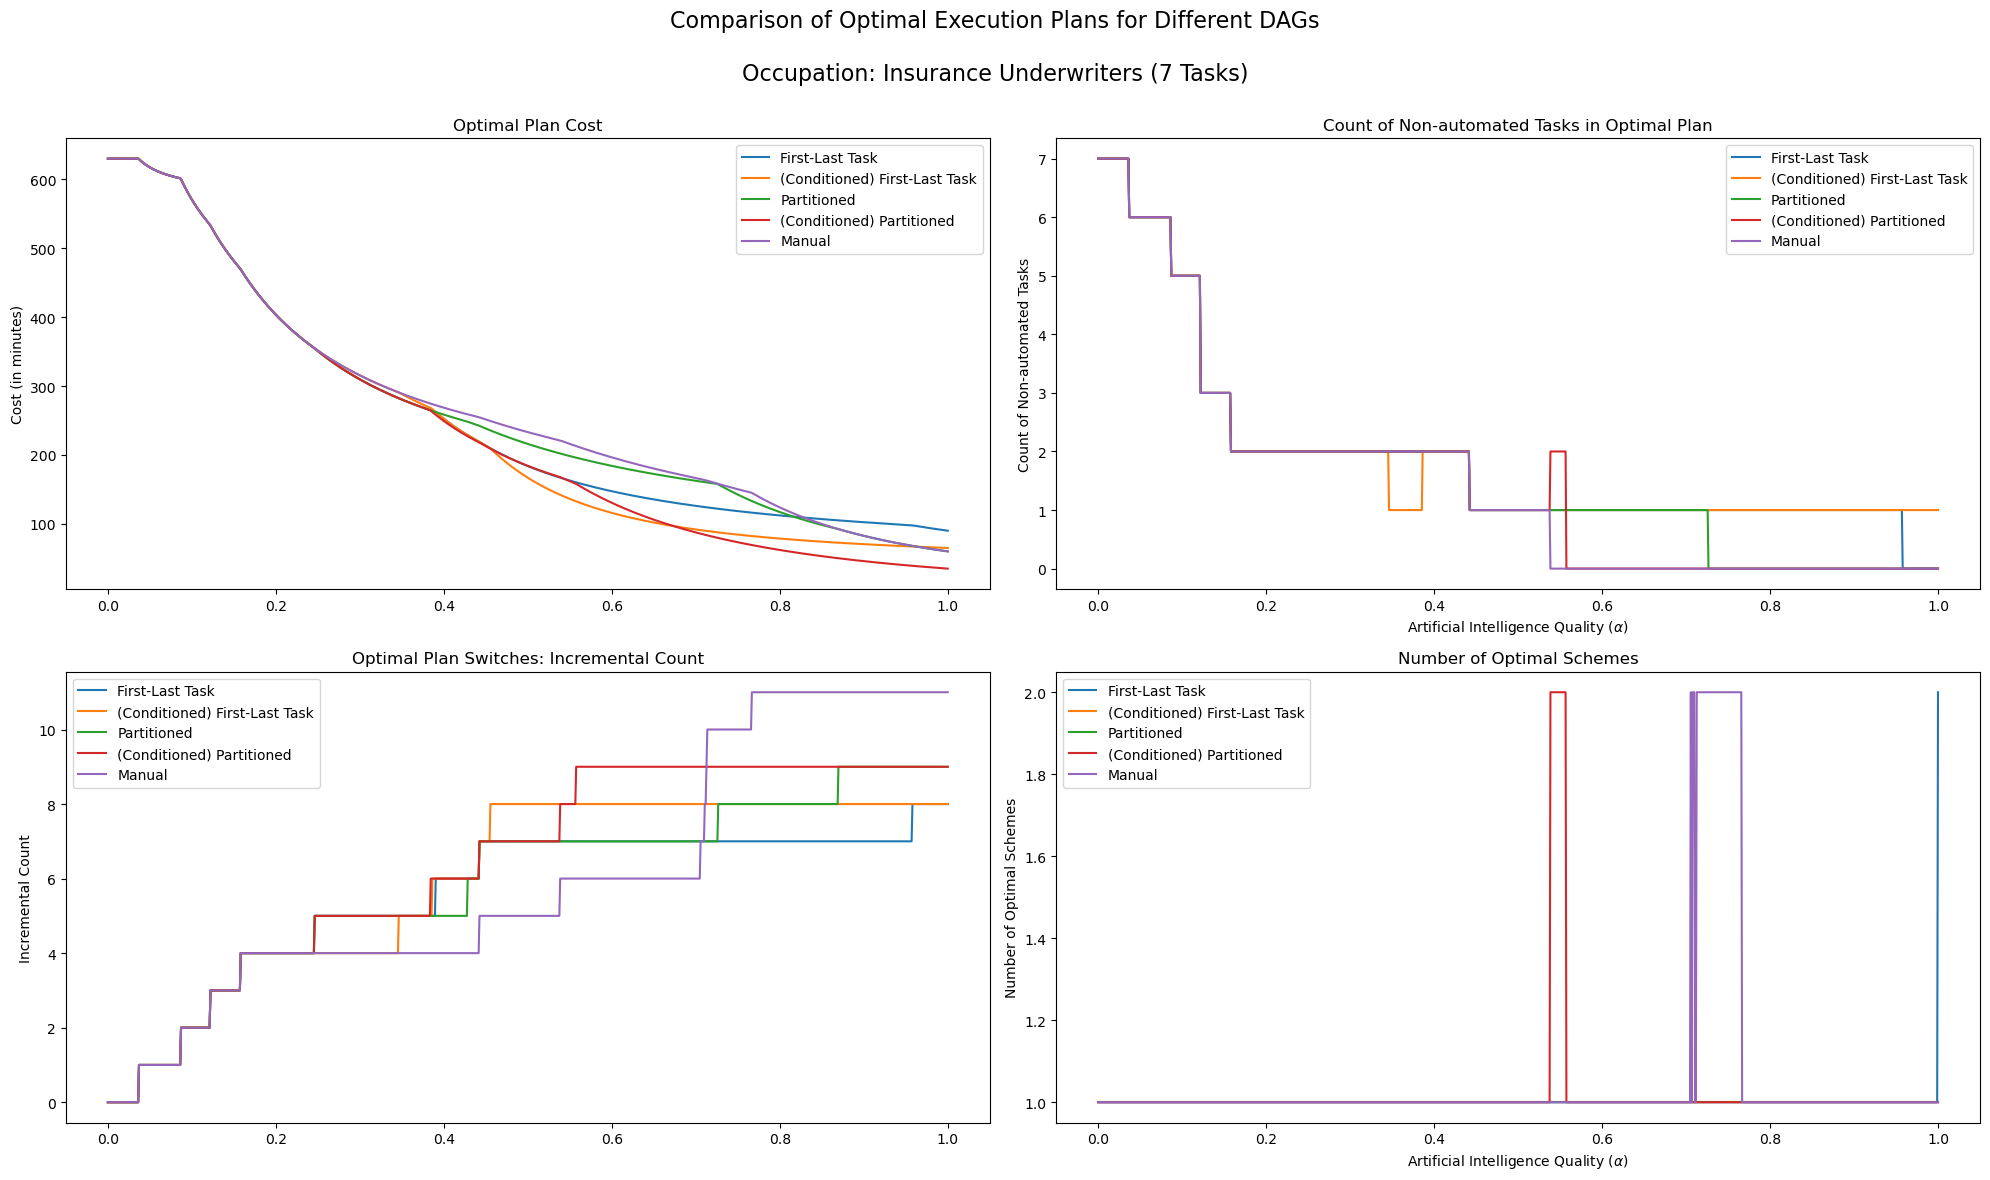

In [864]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle(f'Comparison of Optimal Execution Plans for Different DAGs\n\nOccupation: {plot_title_occupation} ({num_tasks} Tasks)\n', fontsize=16)

# Plot data on the first subplot
axs[0,0].plot(firstLastTask_df.alpha, firstLastTask_df.cost, label = 'First-Last Task')
axs[0,0].plot(firstLastTask_conditioned_df.alpha, firstLastTask_conditioned_df.cost, label = '(Conditioned) First-Last Task')
axs[0,0].plot(partitioned_df.alpha, partitioned_df.cost, label = 'Partitioned')
axs[0,0].plot(partitioned_conditioned_df.alpha, partitioned_conditioned_df.cost, label = '(Conditioned) Partitioned')
if manual_present == 1:
    axs[0,0].plot(manual_df.alpha, manual_df.cost, label = 'Manual')

axs[0,0].set_title('Optimal Plan Cost')
#axs[0,0].set_xlabel(r'Artificial Intelligence Quality ($\alpha$)')
axs[0,0].set_ylabel('Cost (in minutes)')
axs[0,0].legend(loc='upper right')


# Plot data on the second subplot
#axs[1,0].axhline(y=-0, color='red', linestyle='--', alpha=0.9)
axs[0,1].plot(firstLastTask_df.alpha, firstLastTask_df.manual_tasks_count, label = 'First-Last Task')
axs[0,1].plot(firstLastTask_conditioned_df.alpha, firstLastTask_conditioned_df.manual_tasks_count, label = '(Conditioned) First-Last Task')
axs[0,1].plot(partitioned_df.alpha, partitioned_df.manual_tasks_count, label = 'Partitioned')
axs[0,1].plot(partitioned_conditioned_df.alpha, partitioned_conditioned_df.manual_tasks_count, label = '(Conditioned) Partitioned')
if manual_present == 1:
    axs[0,1].plot(manual_df.alpha, manual_df.manual_tasks_count, label = 'Manual')

axs[0,1].set_title('Count of Non-automated Tasks in Optimal Plan')
axs[0,1].set_xlabel(r'Artificial Intelligence Quality ($\alpha$)')
axs[0,1].set_ylabel('Count of Non-automated Tasks')
axs[0,1].legend(loc='upper right')



# Plot data on the third subplot
axs[1,0].plot(comparison_df.alpha, comparison_df.optimal_scheme_FLT_change, label = 'First-Last Task')
axs[1,0].plot(comparison_df.alpha, comparison_df.optimal_scheme_CFLT_change, label = '(Conditioned) First-Last Task')
axs[1,0].plot(comparison_df.alpha, comparison_df.optimal_scheme_P_change, label = 'Partitioned')
axs[1,0].plot(comparison_df.alpha, comparison_df.optimal_scheme_CP_change, label = '(Conditioned) Partitioned')
if manual_present == 1:
    axs[1,0].plot(comparison_df.alpha, comparison_df.optimal_scheme_M_change, label = 'Manual')

axs[1,0].set_title('Optimal Plan Switches: Incremental Count')
#axs[1,0].set_xlabel(r'Artificial Intelligence Quality ($\alpha$)')
axs[1,0].set_ylabel('Incremental Count')
axs[1,0].legend(loc='upper left')


# Plot data on the third subplot
axs[1,1].plot(comparison_df.alpha, comparison_df.optimal_schemes_count_FLT, label = 'First-Last Task')
axs[1,1].plot(comparison_df.alpha, comparison_df.optimal_schemes_count_CFLT, label = '(Conditioned) First-Last Task')
axs[1,1].plot(comparison_df.alpha, comparison_df.optimal_schemes_count_P, label = 'Partitioned')
axs[1,1].plot(comparison_df.alpha, comparison_df.optimal_schemes_count_CP, label = '(Conditioned) Partitioned')
if manual_present == 1:
    axs[1,1].plot(comparison_df.alpha, comparison_df.optimal_schemes_count_M, label = 'Manual')

axs[1,1].set_title('Number of Optimal Schemes')
axs[1,1].set_xlabel(r'Artificial Intelligence Quality ($\alpha$)')
axs[1,1].set_ylabel('Number of Optimal Schemes')
axs[1,1].legend(loc='upper left')



# Adjust the layout
plt.tight_layout()

# Display the plot
plt.savefig(f'{occupation_folder}/{occupation}_costMin_graph.png', dpi=300)